# Segmentation networks

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

sys.path.append('..')
sys.path.append('../task_02')

from dataset import Pipeline, DatasetIndex, Dataset, B, V

from dataset.opensets import MNIST
from dataset.models.tf import UNet
from noised_mnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted       # plot functions to demonstrate result
from utils import count_parameters, smooth

In [2]:
IMAGE_SIZE = 64     # image size
MNIST_SIZE = 65000  # MNIST database size
BATCH_SIZE = 16     # batch size for NN training
MAX_ITER = 1000     # number of iterations for NN training

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 90    # number of noise fragments per image  
size = 5            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

In [4]:
mnistset = MNIST(batch_class=NoisedMnist)

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz





In [5]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                  'type': 'float32',
                                  'name': 'reshaped_images'},
                
                       'masks': {'shape': (IMAGE_SIZE, IMAGE_SIZE),
                                 'type': 'int32',
                                 'transform': 'ohe',
                                 'classes': 2,
                                 'name': 'targets'}
                       }

Create feed dicts. The key is name of the tensor in tf graph, value is batch component.

In [6]:
train_feed_dict = {'images': B('images'),
                   'masks': B('masks')}        

test_feed_dict = {'images': B('images'),
                  'masks': B('masks')}

In [7]:
load_template = (Pipeline()
             .random_location(IMAGE_SIZE)      # put MNIST at random location
             .make_masks()                     # create mask for MNIST image location
             .create_noise('mnist_noise', level, n_fragments, size, distr)
             .add_noise())

In [8]:
def metric(masks, predictions, data_format='channels_last', mode='mse'):
    ind = np.index_exp[:, :, :, 1] if data_format == 'channels_last' else np.index_exp[:, 1, :, :]
    predictions = predictions[ind]
    if mode == 'mse':
         return np.mean((masks - predictions) ** 2)
    elif mode == 'iou':
        intersection = np.sum(np.logical_and((predictions > 0.5), masks), axis=(1, 2))
        union = np.sum(np.logical_or((predictions > 0.5), masks), axis=(1, 2))
        return 1 - np.mean(intersection / union)

In [9]:
def demonstrate_model(model, layout, max_iter=100, batch_size=16):
    
    config={'body/upsample': {'layout': layout, 'factor': 2}}
    
    model_stat = dict()
    stop_level = 0.005
    window = 20
    
    print('Create pipelines...')
    
    model_config = {'inputs': placeholders_config,
                    'input_block/inputs': 'images',
                    'batch_norm': {'momentum': 0.1},
                    'output': dict(ops=['proba']),
                    'loss': 'ce',
                    'optimizer': 'Adam',
                    **config}
    
    ppl_train = ((load_template << mnistset.train)                         # load data from file
            .init_model('static', model, layout, config=model_config)
            .init_variable('loss', init_on_each_run=list)
            .train_model(layout,
                         fetches='loss',
                         feed_dict=train_feed_dict,
                         save_to=V('loss'), mode='a'))
    
    parameters = count_parameters(ppl_train, layout)
    model_stat['params'] = parameters
    
    print('Parameters: {}K'.format(parameters // (10 ** 3)))
    print('Start training...')
    
    test_template = (load_template
                    .import_model(layout, ppl_train)
                    .init_variable('predictions', init_on_each_run=list)
                    .init_variable('masks', init_on_each_run=list)
                    .update_variable('masks', B('masks'), mode='w')
                    .predict_model(layout,                                      
                                   fetches='output_proba',
                                   feed_dict=test_feed_dict,
                                   save_to=V('predictions'),
                                   mode='w'))
    ppl_test = test_template << mnistset.test

    train_time = []
    quality = []
    early_stop = False

    for i in tqdm(range(max_iter)):
        start = time()
        ppl_train.next_batch(batch_size, n_epochs=None, shuffle=True)
        stop = time()
        train_time.append(stop-start)
        
        ppl_test.next_batch(50, n_epochs=None, shuffle=True)
        masks = ppl_test.get_variable('masks')
        predictions = ppl_test.get_variable('predictions')
        quality.append(metric(masks, predictions))
        
        if np.mean(np.array(quality)[-window:] < stop_level) > 0.8:
            early_stop = True
            break

    print('Early stop: {}'.format(early_stop))        
    
    print("Train time: {:05.3f} min".format(sum(train_time)/60))
    
    model_stat['loss_history'] = ppl_train.get_variable('loss')
    model_stat['time'] = train_time
    model_stat['quality_history'] = quality
    model_stat['iters'] = i
    model_stat['ppl'] = ppl_train
    model_stat['early_stop'] = early_stop
    
    print('=' * 20)
    
    return model_stat

stat = dict()

In [17]:
layouts = ['b', 'tna', 'B', 'X']
for layout in layouts:
    print("Layout:", layout)
    stat[layout] = demonstrate_model(UNet, layout, MAX_ITER, BATCH_SIZE)

Layout: tna
Create pipelines...
Parameters: 31118K
Start training...


 21%|███████████████████████████████████▎                                                                                                                                      | 208/1000 [05:06<19:28,  1.48s/it]

Early stop: True
Train time: 1.927 min
Layout: B
Create pipelines...
Parameters: 37041K
Start training...



  0%|                                                                                                                                                                                    | 0/1000 [00:00<?, ?it/s]
Exception in thread Thread-61148:
Traceback (most recent call last):
  File "C:\Anaconda3\envs\tensorflow-gpu\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Anaconda3\envs\tensorflow-gpu\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 32%|██████████████████████████████████████████████████████▉                                                                                                                   | 323/1000 [11:14<23:33,  2.09s/it]


Early stop: True
Train time: 4.920 min
Layout: X
Create pipelines...
Parameters: 37041K
Start training...


 23%|███████████████████████████████████████▍                                                                                                                                  | 232/1000 [05:57<19:42,  1.54s/it]

Early stop: True
Train time: 2.282 min


In [19]:
test_template = (load_template                     
                .init_variable('masks', init_on_each_run=list)
                .init_variable('images', init_on_each_run=list)
                .update_variable('masks', B('masks'), mode='e')
                .update_variable('images', B('images'), mode='e'))

for layout in layouts:
    test_template = (test_template
                     .import_model(layout, stat[layout]['ppl'])
                     .init_variable(layout+'_predictions', init_on_each_run=list)
                     .predict_model(layout,                                      
                                    fetches='output_proba',
                                    feed_dict=test_feed_dict,
                                    save_to=V(layout+'_predictions'),
                                    mode='e'))

print('Start testing...')

ppl_test = test_template << mnistset.test

for i in tqdm(range(50)):
    ppl_test.next_batch(10, n_epochs=1, shuffle=False)

Start testing...



  2%|███▍                                                                                                                                                                          | 1/50 [00:00<00:47,  1.04it/s]
Exception in thread Thread-163485:
Traceback (most recent call last):
  File "C:\Anaconda3\envs\tensorflow-gpu\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Anaconda3\envs\tensorflow-gpu\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.47it/s]


In [20]:
masks = np.array(ppl_test.get_variable('masks'))
images = np.array(ppl_test.get_variable('images'))
for layout in layouts:
    predictions = np.array(ppl_test.get_variable(layout+'_predictions'))
    quality = metric(masks, predictions)

    stat[layout]['predictions'] = predictions
    stat[layout]['quality'] = quality

C:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


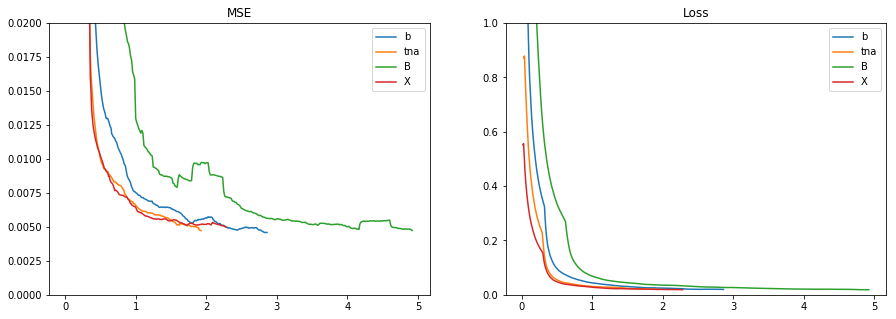

In [29]:
plt.figure(figsize=(15, 5))
for layout in layouts:
    plt.subplot(1, 2, 1)
    x = np.cumsum(stat[layout]['time']) / 60
    y = stat[layout]['quality_history']
    plt.plot(x, smooth(y), label=layout)
    plt.ylim((0, 0.02))
    plt.legend()
    plt.title('MSE')
    plt.subplot(1, 2, 2)
    y = stat[layout]['loss_history']
    plt.plot(x, smooth(y), label=layout)
    plt.ylim((0, 1))
    plt.legend()
    plt.title('Loss')
plt.show()

In [22]:
def stat_table(stat):
    df = dict()
    for layout, layout_stat in stat.items():
        new_stat = {
            'Early stop': layout_stat['early_stop'],
            'Time per iter, s': np.mean(layout_stat['time']),
            'Train time, m': np.sum(layout_stat['time']) / 60,
            'quality': layout_stat['quality'],
            'Parameters': layout_stat['params']
        }
        df[layout] = new_stat
    df = pd.DataFrame(df).transpose()
    return df

In [30]:
stat_table(stat).sort_values(by=['Train time, m'])

,Early stop,Parameters,"Time per iter, s","Train time, m",quality
tna,True,31118466,0.553111,1.92667,0.00461868
X,True,37041986,0.587609,2.28188,0.0041728
b,True,31463746,0.557178,2.86018,0.00447485
B,True,37041986,0.91105,4.91967,0.0041356


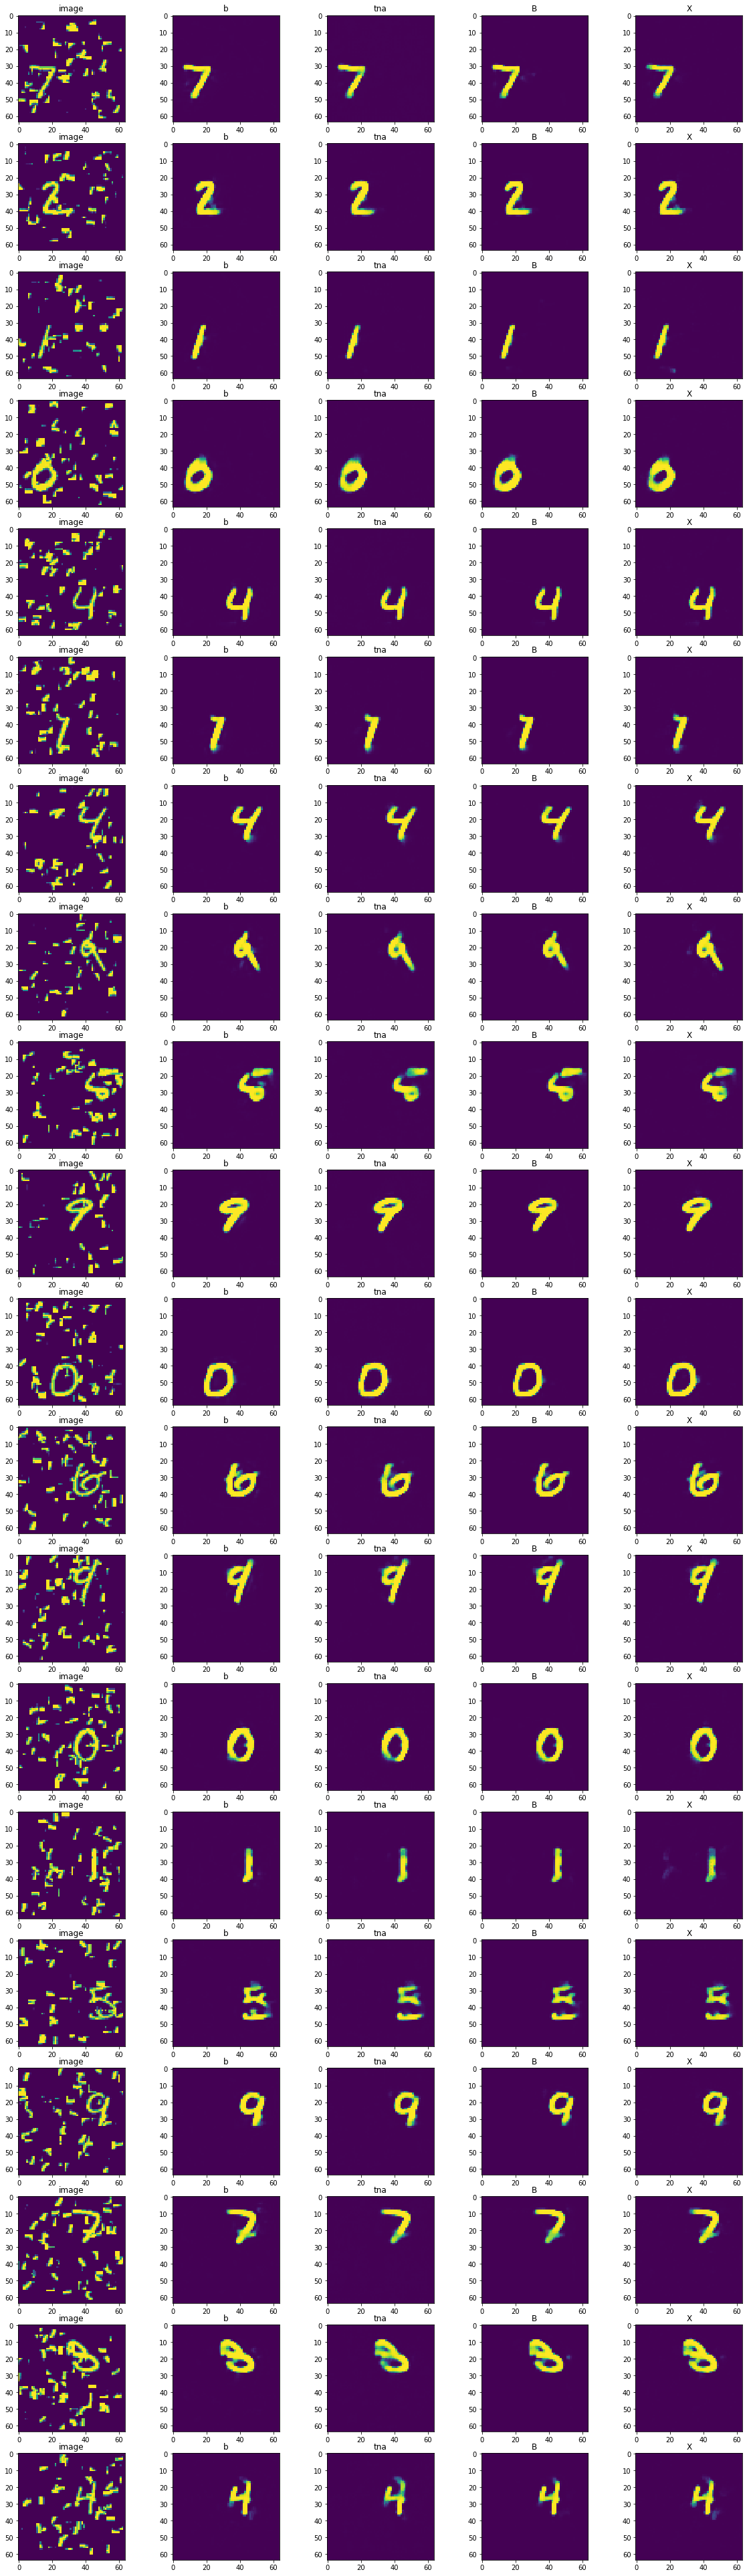

In [27]:
n_examples = 20
plt.figure(figsize=(20,3.5*n_examples))
for i in range(n_examples):
    plt.subplot(n_examples, len(layouts)+1, (len(layouts)+1)*i+1)
    plt.imshow(np.squeeze(images[i]))
    plt.title('image')
    for j, layout in enumerate(layouts):
        mask = stat[layout]['predictions'][i]
        plt.subplot(n_examples, len(layouts)+1, (len(layouts)+1)*i+j+2)
        plt.imshow(mask[:,:,1])
        plt.title(layout)
plt.show()